In [3]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL.ImageChops import constant
from Scripts.pywin32_testall import project_root
from scipy.stats import obrientransform
import sys
from matplotlib import pyplot as plt
from pathlib import Path
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path().resolve().parent
sys.path.append(str(project_root))
from src.utils.eda_utils import missingness,summarize

In [4]:
Root_dir = Path.cwd().parent
data_dir = Path(Root_dir.joinpath('data/raw/tlc/yellow/2023'))
zone_path = Path(Root_dir.joinpath('data/raw/tlc/misc/taxi_zone_lookup.csv'))
file_1 = Path(data_dir.joinpath('yellow_tripdata_2023-01.parquet'))

In [5]:
df = pd.read_parquet(file_1)

In [6]:
numeric_all = df.select_dtypes(include="number").columns.tolist()
exclude_ids = [c for c in ["VendorID","RatecodeID","PULocationID","DOLocationID","payment_type","trip_type"]
               if c in df.columns]
cols = [c for c in numeric_all if c not in exclude_ids]

In [7]:
print(f"Numeric columns selected: {len(cols)} (excluded IDs: {len(exclude_ids)})")

Numeric columns selected: 11 (excluded IDs: 5)


In [8]:
num_sum = summarize(df, cols)

In [9]:
out_path = Root_dir / "reports" / "tables" / "num_summary.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
num_sum.sort_values("name").to_csv(out_path, index=False)

In [10]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [11]:
plot_distance = df['trip_distance'].dropna().astype(float)
n = len(plot_distance)
q25 , q75 = np.percentile(plot_distance, [25, 75])
iqr = float(q75 - q25)
h = float (2 * iqr * (n ** (-1/3)))
lo = q25 - 1.5*iqr
hi = q75 + 1.5*iqr

In [12]:
p1, p99 = np.percentile(plot_distance, [1, 99])
if not np.isfinite(p1) or not np.isfinite(p99) or p99 <= p1:
    p1, p99 = float(plot_distance.min()), float(plot_distance.max())

In [13]:
if iqr <= 0 or h <= 0:
    bins = int(np.ceil(1 + np.log2(plot_distance)))
else:
    bins = int(np.ceil((p99 - p1) / h))
bins = max(10, min(bins, 200))

In [14]:
fig_dir = Root_dir / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)
png_linear = fig_dir / "hist_trip_distance_fd.png"
png_logx  = fig_dir / "hist_trip_distance_fd_logx.png"
fig_dir

WindowsPath('D:/Portfolio/eda-portfolio/reports/figures')

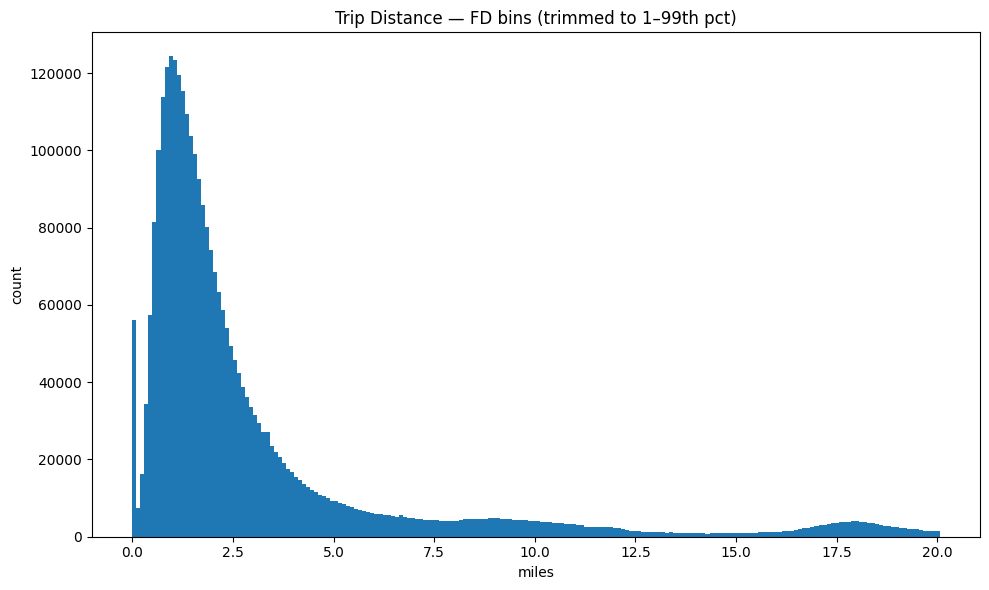

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(plot_distance, bins=bins, range=(p1, p99))
plt.title("Trip Distance — FD bins (trimmed to 1–99th pct)")
plt.xlabel("miles")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(png_linear, dpi=120)
plt.show()

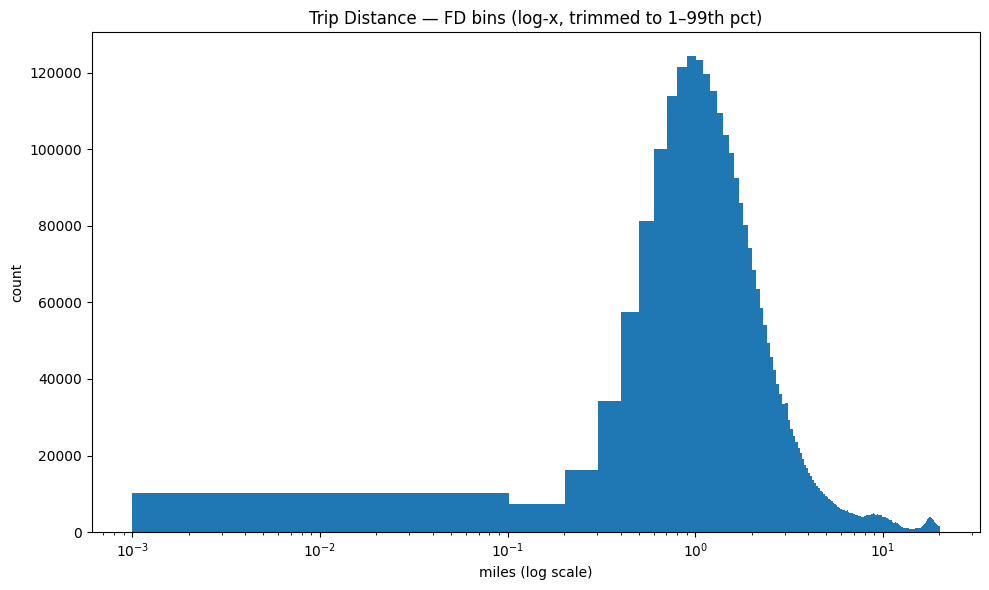

In [16]:
p1_log = max(p1, 1e-3)
plt.figure(figsize=(10, 6))
plt.hist(plot_distance, bins=bins, range=(p1_log, p99))
plt.xscale("log")
plt.title("Trip Distance — FD bins (log-x, trimmed to 1–99th pct)")
plt.xlabel("miles (log scale)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(png_logx, dpi=120)
plt.show()

In [17]:
num_outlier = (plot_distance < lo) | (plot_distance > hi)
num_outlier_trip_distance = num_outlier.sum()
pct_outlier_among_non_missing = num_outlier_trip_distance / plot_distance.size * 100
pct_outlier_all = num_outlier_trip_distance / df.shape[0] * 100

In [18]:
print(pct_outlier_among_non_missing , pct_outlier_all )

12.724935648823548 12.724935648823548


In [19]:
sample_mean = plot_distance.mean()
sample_std = plot_distance.std(ddof=1)
if sample_std == 0 or plot_distance.size < 2 or not np.isfinite(sample_std):
    mask_z = pd.series.isna(False, index=plot_distance.index)
else:
    z = (plot_distance - sample_mean) / sample_std
    mask_z = z.abs() > 3.0

n_z = int(mask_z.sum())
pct_z_non_missing = 100 * n_z / plot_distance.size
pct_z_all         = 100 * n_z / len(df)

In [20]:
print(f"mean={sample_mean:.3f}, std={sample_std:.3f}, thr={3.0}")
print(f"z-outliers: {n_z}  |  {pct_z_non_missing:.3f}% of non-missing  |  {pct_z_all:.3f}% of all rows")

mean=3.847, std=249.584, thr=3.0
z-outliers: 67  |  0.002% of non-missing  |  0.002% of all rows


In [21]:
x_all = df["trip_distance"].astype(float)
x = x_all.dropna()
n_all = len(x_all)
n_nonmiss = len(x)

In [22]:
q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lo = q1 - 1.5 * iqr
hi = q3 + 1.5 * iqr
mask_iqr = (x < lo) | (x > hi)
n_iqr = int(mask_iqr.sum())
pct_iqr_nm = 100 * n_iqr / n_nonmiss
pct_iqr_all = 100 * n_iqr / n_all

In [23]:
q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lo = q1 - 1.5 * iqr
hi = q3 + 1.5 * iqr
mask_iqr = (x < lo) | (x > hi)
n_iqr = int(mask_iqr.sum())
pct_iqr_nm = 100 * n_iqr / n_nonmiss
pct_iqr_all = 100 * n_iqr / n_all

# 2) z-score fences & counts (thr=3)
thr = 3.0
mean = float(x.mean())
std = float(x.std(ddof=1))
if (not np.isfinite(std)) or (std == 0) or (n_nonmiss < 2):
    n_z = 0
    lo_z = np.nan
    hi_z = np.nan
else:
    z = (x - mean) / std
    mask_z = z.abs() > thr
    n_z = int(mask_z.sum())
    lo_z = mean - thr * std
    hi_z = mean + thr * std
pct_z_nm = 100 * n_z / n_nonmiss if n_nonmiss else 0.0
pct_z_all = 100 * n_z / n_all if n_all else 0.0

In [24]:
out_df = pd.DataFrame([
    {"feature":"trip_distance","method":"IQR","lower_fence":lo,"upper_fence":hi,
     "n_outliers":n_iqr,"pct_non_missing":pct_iqr_nm,"pct_all":pct_iqr_all},
    {"feature":"trip_distance","method":"zscore","lower_fence":lo_z,"upper_fence":hi_z,
     "n_outliers":n_z,"pct_non_missing":pct_z_nm,"pct_all":pct_z_all}
])

Root_dir = globals().get("Root_dir", Path.cwd().parent)
out_path = Root_dir / "reports" / "tables" / "outlier_trip_distance.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
out_df.to_csv(out_path, index=False)

In [25]:
q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lo = q1 - 3.0 * iqr
hi = q3 + 3.0 * iqr
mask_iqr = (x < lo) | (x > hi)
n_iqr = int(mask_iqr.sum())
pct_iqr_nm = 100 * n_iqr / n_nonmiss
pct_iqr_all = 100 * n_iqr / n_all

# 2) z-score fences & counts (thr=3)
thr = 3.0
mean = float(x.mean())
std = float(x.std(ddof=1))
if (not np.isfinite(std)) or (std == 0) or (n_nonmiss < 2):
    n_z = 0
    lo_z = np.nan
    hi_z = np.nan
else:
    z = (x - mean) / std
    mask_z = z.abs() > thr
    n_z = int(mask_z.sum())
    lo_z = mean - thr * std
    hi_z = mean + thr * std
pct_z_nm = 100 * n_z / n_nonmiss if n_nonmiss else 0.0
pct_z_all = 100 * n_z / n_all if n_all else 0.0

In [26]:
out_df = pd.DataFrame([
    {"feature":"trip_distance","method":"IQR","lower_fence":lo,"upper_fence":hi,
     "n_outliers":n_iqr,"pct_non_missing":pct_iqr_nm,"pct_all":pct_iqr_all},
    {"feature":"trip_distance","method":"zscore","lower_fence":lo_z,"upper_fence":hi_z,
     "n_outliers":n_z,"pct_non_missing":pct_z_nm,"pct_all":pct_z_all}
])

Root_dir = globals().get("Root_dir", Path.cwd().parent)
out_path = Root_dir / "reports" / "tables" / "outlier_trip_distance_w_3.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
out_df.to_csv(out_path, index=False)

In [27]:
x_all = df["trip_distance"].astype(float)
x = x_all.dropna()
n_all = len(x_all)
n_nonmiss = len(x)

In [28]:
p99, p995, p999 = np.percentile(x, [99, 99.5, 99.9])
tail_thr = max(50.0, p995)

In [29]:
mask_tail = x > tail_thr
n_tail = int(mask_tail.sum())
pct_tail_nm = 100 * n_tail / n_nonmiss
pct_tail_all = 100 * n_tail / n_all

In [30]:
print(f"p99={p99:.3f} | p99.5={p995:.3f} | p99.9={p999:.3f} | tail_thr={tail_thr:.3f}")
print(f"tail outliers: {n_tail}  |  {pct_tail_nm:.3f}% of non-missing  |  {pct_tail_all:.3f}% of all rows")


p99=20.060 | p99.5=21.500 | p99.9=28.800 | tail_thr=50.000
tail outliers: 387  |  0.013% of non-missing  |  0.013% of all rows


In [31]:
out_cols = ["feature","method","lower_fence","upper_fence","n_outliers","pct_non_missing","pct_all"]
new_row = pd.DataFrame([{
    "feature": "trip_distance",
    "method": "quantile_99.5",
    "lower_fence": np.nan,
    "upper_fence": float(tail_thr),
    "n_outliers": n_tail,
    "pct_non_missing": pct_tail_nm,
    "pct_all": pct_tail_all
}], columns=out_cols)

out_path = Root_dir / "reports" / "tables" / "outlier_trip_distance.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
if out_path.exists():
    prev = pd.read_csv(out_path)
    # align columns in case of different order
    prev = prev.reindex(columns=out_cols)
    out_df = pd.concat([prev, new_row], ignore_index=True)
else:
    out_df = new_row

out_df.to_csv(out_path, index=False)
out_df.tail(3)

,feature,method,lower_fence,upper_fence,n_outliers,pct_non_missing,pct_all
0,trip_distance,IQR,-2.345000,6.73500,390244,12.724936,12.724936
1,trip_distance,zscore,-744.903926,752.59861,67,0.002185,0.002185
2,trip_distance,quantile_99.5,NaN,50.00000,387,0.012619,0.012619


In [32]:
s_all = df["trip_distance"].astype(float)
n_all = len(s_all)


In [33]:
s = s_all.dropna()
n_nonmiss = len(s)

In [34]:
s_nonneg = s.clip(lower=0.0)
x = np.log1p(s_nonneg)

In [35]:
q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
k = 1.5

In [36]:
if iqr <= 0 or not np.isfinite(iqr):
    # degenerate case: no spread → no outliers by this rule
    lo_log = np.nan
    hi_log = np.nan
    lo = np.nan
    hi = np.nan
    mask_logiqr = pd.Series(False, index=s.index)
else:
    lo_log = q1 - k * iqr
    hi_log = q3 + k * iqr
    # map fences back to miles
    lo = float(np.expm1(lo_log))
    hi = float(np.expm1(hi_log))
    mask_logiqr = (s < lo) | (s > hi)

In [37]:
n_logiqr = int(mask_logiqr.sum())
pct_logiqr_nm = 100 * n_logiqr / n_nonmiss
pct_logiqr_all = 100 * n_logiqr / n_all

print(f"log-IQR fences (k={k}):")
print(f"  Q1_log={q1:.4f}, Q3_log={q3:.4f}, IQR_log={iqr:.4f}")
print(f"  lower={lo:.3f} mi, upper={hi:.3f} mi")
print(f"Outliers (log-IQR): {n_logiqr}  |  {pct_logiqr_nm:.3f}% of non-missing  |  {pct_logiqr_all:.3f}% of all rows")


log-IQR fences (k=1.5):
  Q1_log=0.7227, Q3_log=1.4656, IQR_log=0.7429
  lower=-0.324 mi, upper=12.195 mi
Outliers (log-IQR): 178375  |  5.816% of non-missing  |  5.816% of all rows


In [38]:
new_row = pd.DataFrame([{
    "feature": "trip_distance",
    "method": "logIQR_k1.5",
    "lower_fence": lo,
    "upper_fence": hi,
    "n_outliers": n_logiqr,
    "pct_non_missing": pct_logiqr_nm,
    "pct_all": pct_logiqr_all
}])

if out_path.exists():
    prev = pd.read_csv(out_path)
    # align columns if order differs
    cols = ["feature","method","lower_fence","upper_fence","n_outliers","pct_non_missing","pct_all"]
    prev = prev.reindex(columns=cols)
    out_df = pd.concat([prev, new_row], ignore_index=True)
else:
    out_df = new_row

out_df.to_csv(out_path, index=False)
print(f"✓ Appended log-IQR row → {out_path}  |  rows={out_df.shape[0]}")
out_df.tail(3)

✓ Appended log-IQR row → D:\Portfolio\eda-portfolio\reports\tables\outlier_trip_distance.csv  |  rows=4


,feature,method,lower_fence,upper_fence,n_outliers,pct_non_missing,pct_all
1,trip_distance,zscore,-744.903926,752.598610,67,0.002185,0.002185
2,trip_distance,quantile_99.5,NaN,50.000000,387,0.012619,0.012619
3,trip_distance,logIQR_k1.5,-0.324016,12.195289,178375,5.816388,5.816388


In [43]:
trip_csv = Root_dir / "reports" / "tables" / "outlier_trip_distance.csv"
odf = pd.read_csv(trip_csv)
row = odf[(odf["feature"]=="trip_distance") & (odf["method"]=="logIQR_k1.5")]
upper_fence = float(row["upper_fence"].iloc[0])
lower_fence = 0.0  # physics override

policy_entry = {
    "method": "logIQR_k1.5",
    "lower_fence": lower_fence,
    "upper_fence": upper_fence,
    "action": "flag_only",
    "notes": "Linear IQR too strict; z-score too wide. Log-IQR balances tail.",
    "computed_on": "2023-01"
}

cfg_path = Root_dir / "configs" / "outlier_policies.json"
cfg_path.parent.mkdir(parents=True, exist_ok=True)

# 3) merge/append by feature name
if cfg_path.exists():
    with open(cfg_path, "r") as f:
        cfg = json.load(f)
    if not isinstance(cfg, dict):
        cfg = {}
else:
    cfg = {}

cfg.setdefault("policies", {})
cfg["policies"]["trip_distance"] = policy_entry

with open(cfg_path, "w") as f:
    json.dump(cfg, f, indent=2)

# 4) (optional) create a flag column in df (no dropping)
if "df" not in globals():
    DATA_PATH = Root_dir / "data" / "raw" / "tlc" / "yellow" / "2023" / "yellow_tripdata_2023-01.parquet"
    df = pd.read_parquet(DATA_PATH)

flag_col = "trip_distance_outlier"
df[flag_col] = (df["trip_distance"] < lower_fence) | (df["trip_distance"] > upper_fence)

print(f"✓ Saved policy → {cfg_path}")
print(f"Upper fence = {upper_fence:.3f} mi | Lower fence = {lower_fence:.3f} mi")
print(f"Flagged {df[flag_col].sum():,} rows ({100*df[flag_col].mean():.3f}% of all rows) as trip_distance outliers (flag-only).")

✓ Saved policy → D:\Portfolio\eda-portfolio\configs\outlier_policies.json
Upper fence = 12.195 mi | Lower fence = 0.000 mi
Flagged 178,375 rows (5.816% of all rows) as trip_distance outliers (flag-only).


✓ Saved Pearson correlation matrix → D:\Portfolio\eda-portfolio\reports\tables\corr_pearson.csv  |  shape=(11, 11)


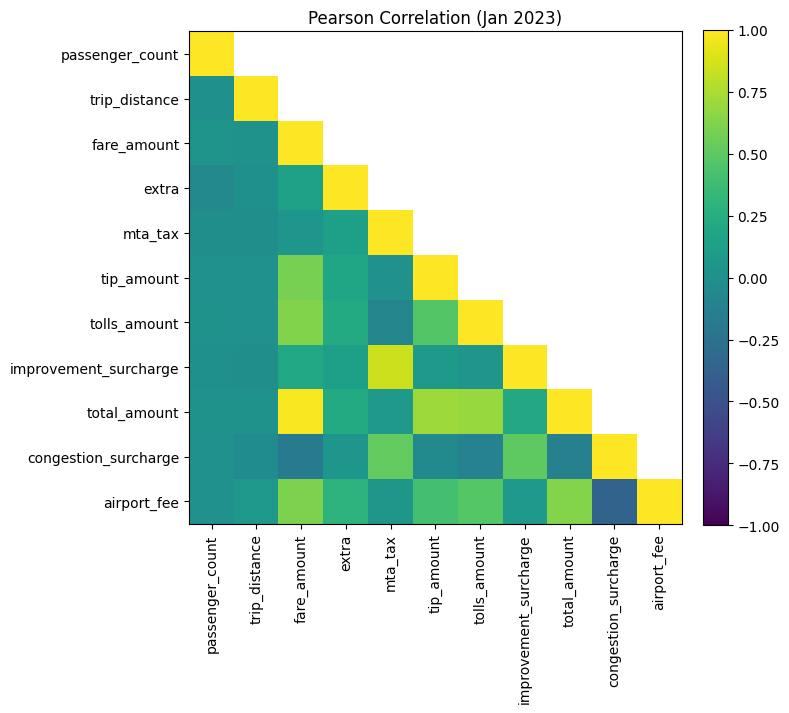

✓ Saved heatmap → D:\Portfolio\eda-portfolio\reports\figures\corr_pearson.png


In [44]:
Root_dir = globals().get("Root_dir", Path.cwd().parent)
if "df" not in globals():
    DATA_PATH = Root_dir / "data" / "raw" / "tlc" / "yellow" / "2023" / "yellow_tripdata_2023-01.parquet"
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded {DATA_PATH.name} → shape={df.shape}")

# 1) choose numeric columns, excluding ID-like codes (not true measurements)
numeric_all = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_ids = [c for c in ["VendorID","RatecodeID","PULocationID","DOLocationID","payment_type","trip_type"] if c in df.columns]
cols = [c for c in numeric_all if c not in exclude_ids]
assert len(cols) > 0, "No numeric columns selected."

# 2) compute Pearson correlation
corr = df[cols].corr(method="pearson", min_periods=1)

# 3) save full matrix to CSV
corr_csv = Root_dir / "reports" / "tables" / "corr_pearson.csv"
corr_csv.parent.mkdir(parents=True, exist_ok=True)
corr.to_csv(corr_csv, index=True)
print(f"✓ Saved Pearson correlation matrix → {corr_csv}  |  shape={corr.shape}")

# 4) simple heatmap (lower triangle) with Matplotlib
vals = corr.values
mask_upper = np.triu(np.ones_like(vals, dtype=bool), k=1)
vals_masked = np.ma.masked_where(mask_upper | ~np.isfinite(vals), vals)  # mask upper & NaNs

n = len(cols)
figsize = (max(8, 0.5*n), max(8, 0.5*n))

plt.figure(figsize=figsize)
im = plt.imshow(vals_masked, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Pearson Correlation (Jan 2023)")
plt.xticks(range(n), cols, rotation=90)
plt.yticks(range(n), cols)
plt.tight_layout()

corr_png = Root_dir / "reports" / "figures" / "corr_pearson.png"
corr_png.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(corr_png, dpi=140)
plt.show()

print(f"✓ Saved heatmap → {corr_png}")